# The percentage of cells in the S-phase

Joachim Goedhart

## About

We summarize and display the data that is measured by students in the course “Cellulaire Oncologie”. HeLa cells were incubated with EdU and subjected to click chemistry to label the cells in the S-phase. The students analyzed the images by hand and with an image analysis procedure (based on thresholding and particle analysis) in ImageJ/FIJI.

The data of each student is submitted through a Google Form and collected in a Google Sheet. The students also provide information on the group that they are in, as the group is treated as an independent variable.

First, we load the necessary R packages for data handling and plotting:

In [ ]:
library(tidyverse)


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Next, we read the data from the Google Sheet and modify the column names:

In [ ]:
df_sheet <- read.csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vQztaYnSPoe_meMwCIOxBZ7QsWgF-C3ChVM7YqWsHjkGvd51-vB442lOCC_zusWkLw-kaEJJf1bLYz6/pub?output=csv", na.strings = "")
df_sheet <- df_sheet %>% na.omit()

colnames(df_sheet) <- c("Timestamp", "Group", "manual", "automated")
df_tidy <-
    pivot_longer(
        df_sheet,
        cols = -c("Timestamp", "Group"),
        names_to = "Analysis",
        values_to = "S_phase"
    ) %>% mutate(S_phase = gsub(" ", "", S_phase))


We do some cleaning to make sure that we have numbers only and that the values are in the appropriate range (0%-100%):

In [ ]:
df_clean <- df_tidy %>% mutate(S_phase = as.numeric(S_phase)) %>% filter(S_phase>0 & S_phase<100)


Warning in mask$eval_all_mutate(quo): NAs introduced by coercion

The column with Timestamp data are split, to have individual columns for the day, month and year:

In [ ]:
df <- df_clean %>% separate('Timestamp', c("Date", "Time"), sep=" ") %>%
    separate('Date', c("day", "month", "year"), sep="-", convert = TRUE)


## Visualization

We can make a first plot that shows the distribution of the values for both type of analyses. This will give some impression of an average percentage of cells that are in the S-phase:

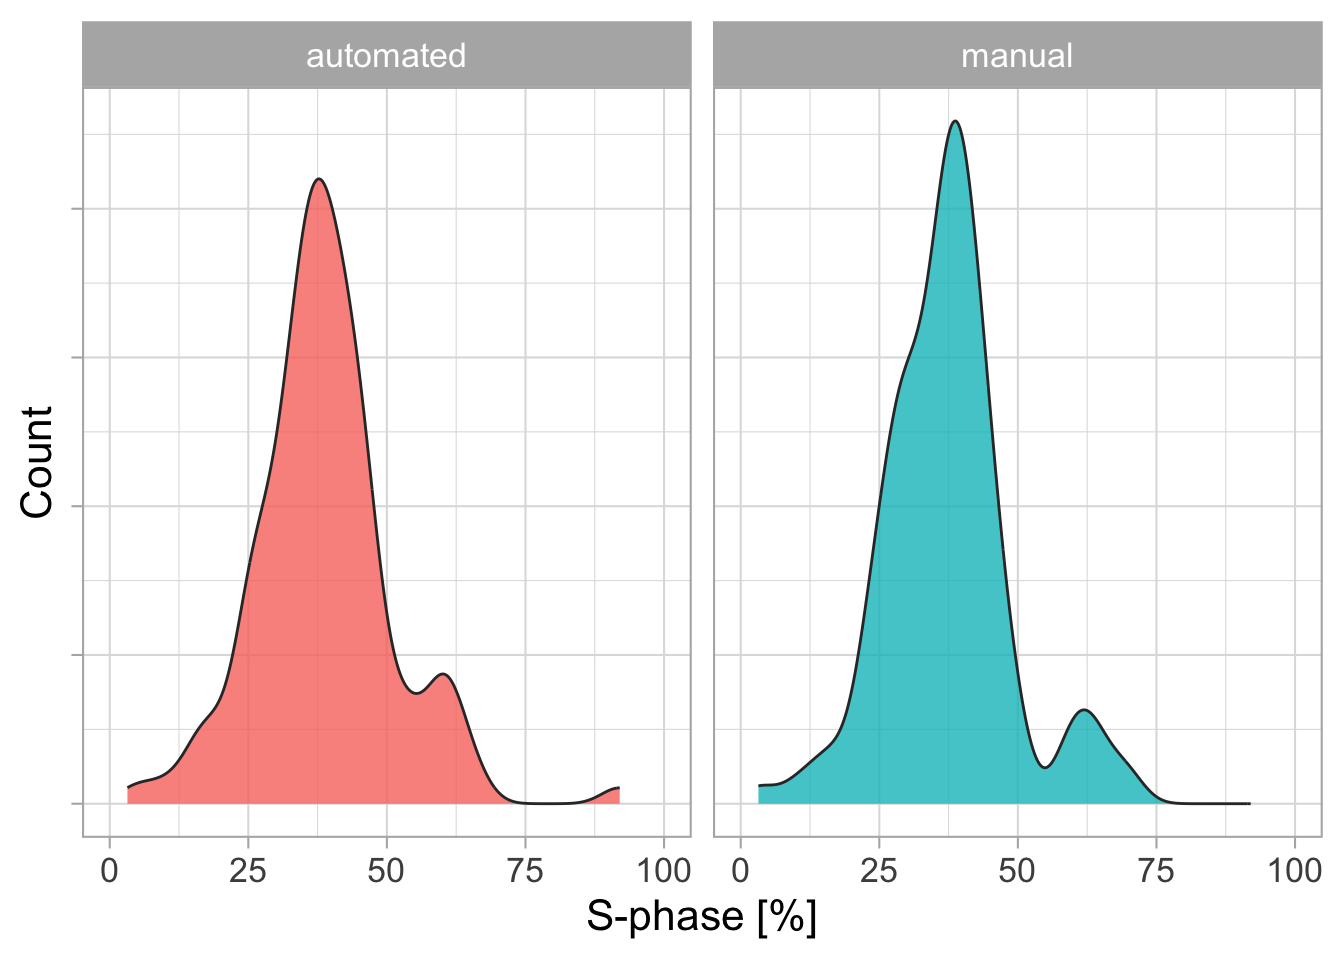

In [ ]:
        p <- ggplot(df, aes(x=S_phase, fill=Analysis))

        p <- p + geom_density(alpha=0.8, color='grey20')

        p <- p + labs(y="Count", x="S-phase [%]")

        p <- p + coord_cartesian(xlim = c(0,100))

        p <- p + theme_light(base_size = 16) + theme(axis.text.y = element_blank())
        p <- p + facet_wrap(~Analysis)
        p <- p + theme(legend.position = "none")
        
        p


The distributions for the automated and manual analysis look similar. Since every student did the analysis by hand and in automated fashion, we can directly compare these ‘paired’ data and we split it for the different years:

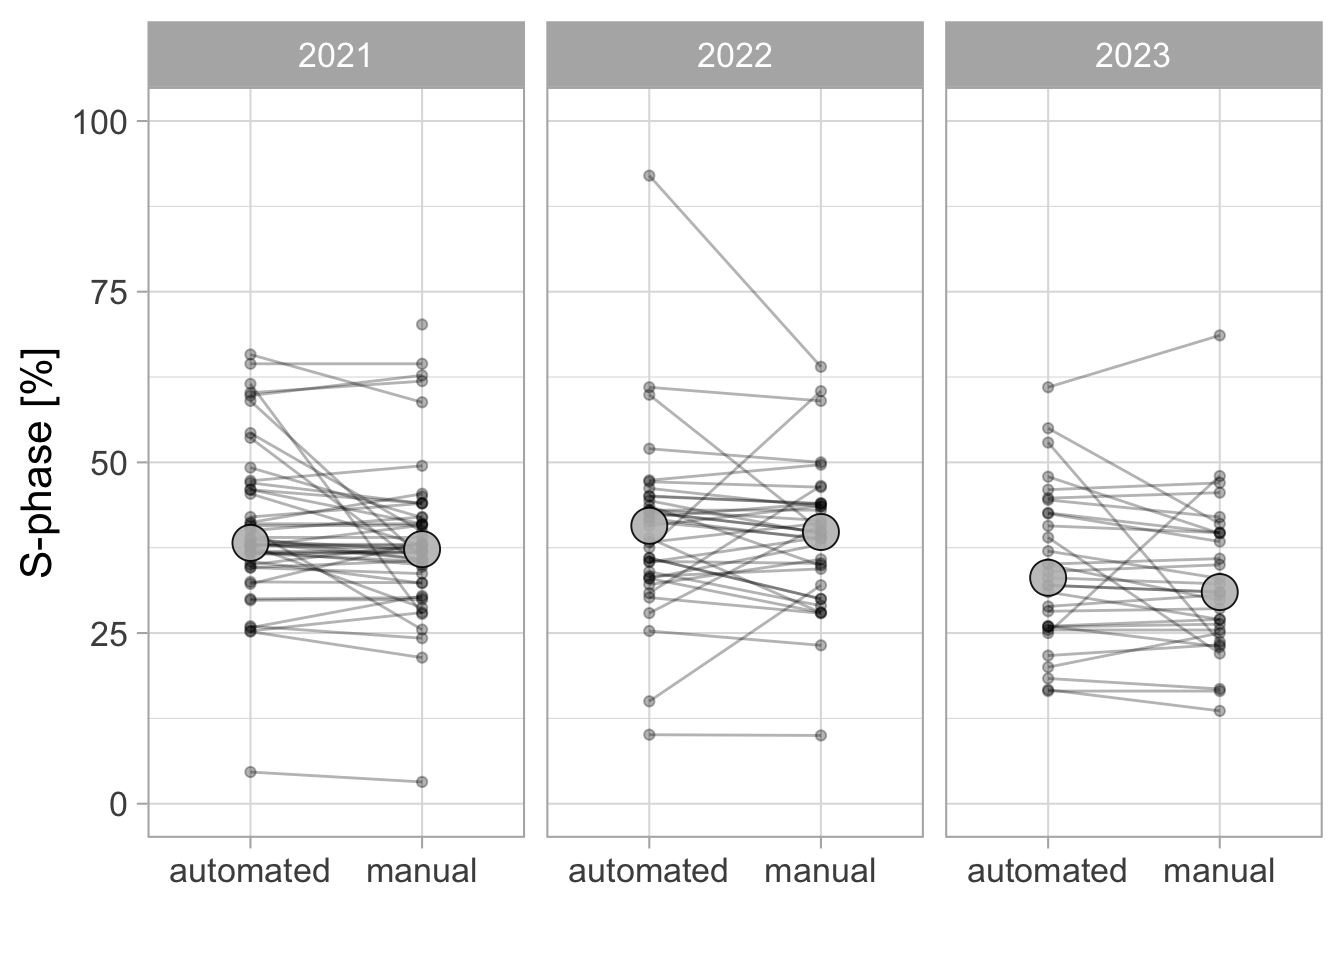

In [ ]:
        p <- ggplot(df, aes(x=Analysis, y=S_phase))

        p <- p + geom_point(alpha=0.3)  +
          geom_line(aes(group=Time), alpha=0.3) +
          stat_summary(fun = median, geom = "point", size=6, shape=21, fill="grey", alpha=0.9)
        p <- p + labs(x="", y="S-phase [%]")

        p <- p + coord_cartesian(ylim = c(0,100))

        p <- p + theme_light(base_size = 16) 
        p <- p + facet_wrap(~year)
        p


Each paired measurement is connected with a line and the slopes of the line vary substantially. Still, the average value (the large grey dot) for the two different counting methods is similar for each year. There is a difference for the averages between years, and this may be true biological variation between the cell cultures.

To get a fair estimate of the percentage of cells in the S-phase, we treat treat each group in each year as an independent measurement. Each of these independent measurements consists of multiple measurements (technical replicates) and we can plot this in a ‘superplot’ style, see also [Lord at al. (2020)](https://doi.org/10.1083/jcb.202001064). The individual measurements are shown as small dots and their median as a large dot:

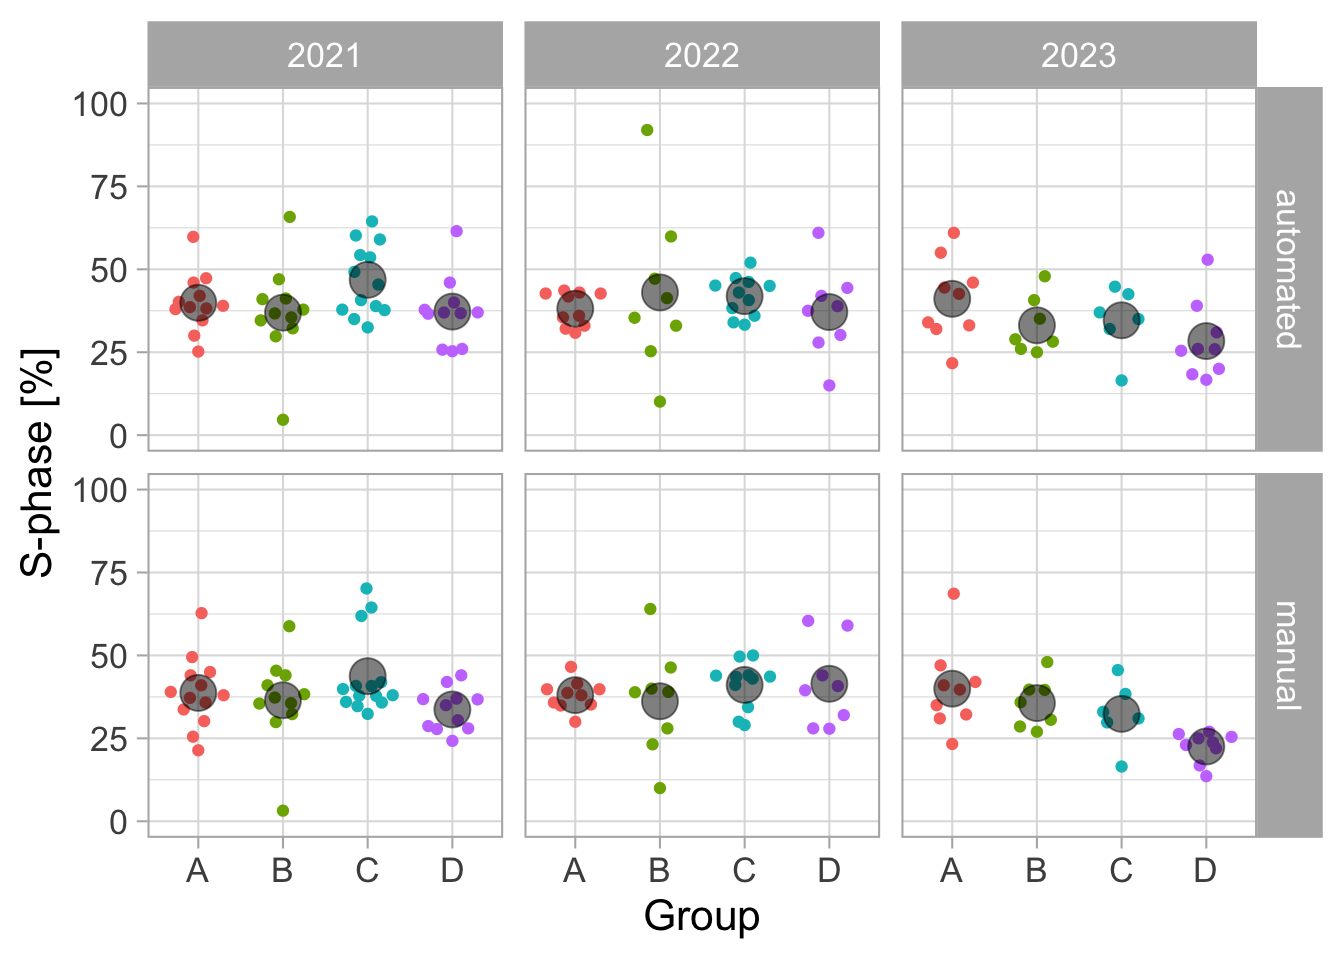

In [ ]:
p <- ggplot(df, aes(x=Group, y=S_phase, color=Group))
p <- p + geom_quasirandom() +  stat_summary(fun = mean, geom = "point", size=6, color="black", alpha=0.5)
        
p <- p + labs(x="Group", y="S-phase [%]")
p <- p + coord_cartesian(ylim = c(0,100))
        
p <- p + theme_light(base_size = 16)
p <- p + theme(legend.position = "none") + facet_grid(Analysis~year)

p


We consider the manual analysis (nuclei counted by hand) as the ground truth. So I only select the manually processed data:

In [ ]:
df_manual <- df %>% filter(Analysis == 'manual')


Next, I merge the date and group data, as this will give a column that reflects independent measurements:

In [ ]:
df_results <- df_manual %>% unite(Replicate, c(year, Group), sep=" ")


This data set will be saved, as it can be used as input for [SuperPlotsOfData](https://doi.org/10.1091/mbc.E20-09-0583):

In [ ]:
df_results %>% write.csv("results_S-phase.csv")


The [SuperPlotsOfData app](https://huygens.science.uva.nl/SuperPlotsOfData/) plots the data and calculates the statistics. We can repeat the calculations and the data analysis here. First we generate a dataframe that summarizes all individual measurements per independent measurement (defined by the column ‘Replicate’):

In [ ]:
df_summary <- df_results %>% group_by(Replicate, Analysis) %>% summarize(n=n(), Percentage=mean(S_phase))


`summarise()` has grouped output by 'Replicate'. You can override using the
`.groups` argument.

# A tibble: 12 × 4
# Groups:   Replicate [12]
   Replicate Analysis     n Percentage
   <chr>     <chr>    <int>      <dbl>
 1 2021 A    manual      13       38.7
 2 2021 B    manual      11       36.5
 3 2021 C    manual      14       43.7
 4 2021 D    manual      11       33.7
 5 2022 A    manual      10       38.0
 6 2022 B    manual       8       36.2
 7 2022 C    manual      11       41.1
 8 2022 D    manual       8       41.4
 9 2023 A    manual       9       40.0
10 2023 B    manual       7       35.6
11 2023 C    manual       6       32.4
12 2023 D    manual       9       22.5

We can use these data to calculate a precise estimate of the percentage of HeLa cells in the S-phase:

In [ ]:
df_S <- df_summary %>% ungroup() %>% summarise(N=n(),
                                               Average = mean(Percentage),
                                               sd = sd(Percentage, na.rm = TRUE)) %>%
  mutate(sem = sd / sqrt(N - 1),
         mean_CI_lo = Average + qt((1-0.95)/2, N - 1) * sem,
         mean_CI_hi = Average - qt((1-0.95)/2, N - 1) * sem)


These are the resulting statistics:

In [ ]:
df_S %>% select(-c('sd', 'sem')) %>% round(1)  %>% unite(`95% CI`, c(mean_CI_lo, mean_CI_hi), sep=" - ")


# A tibble: 1 × 3
      N Average `95% CI` 
  <dbl>   <dbl> <chr>    
1    12    36.7 33 - 40.3

Let’s now generate a superplot for the individual replicates, repeating what can be done in the app with the data in \`results_S-phase.csv\`\`. First we generate dotplots from the replicates:

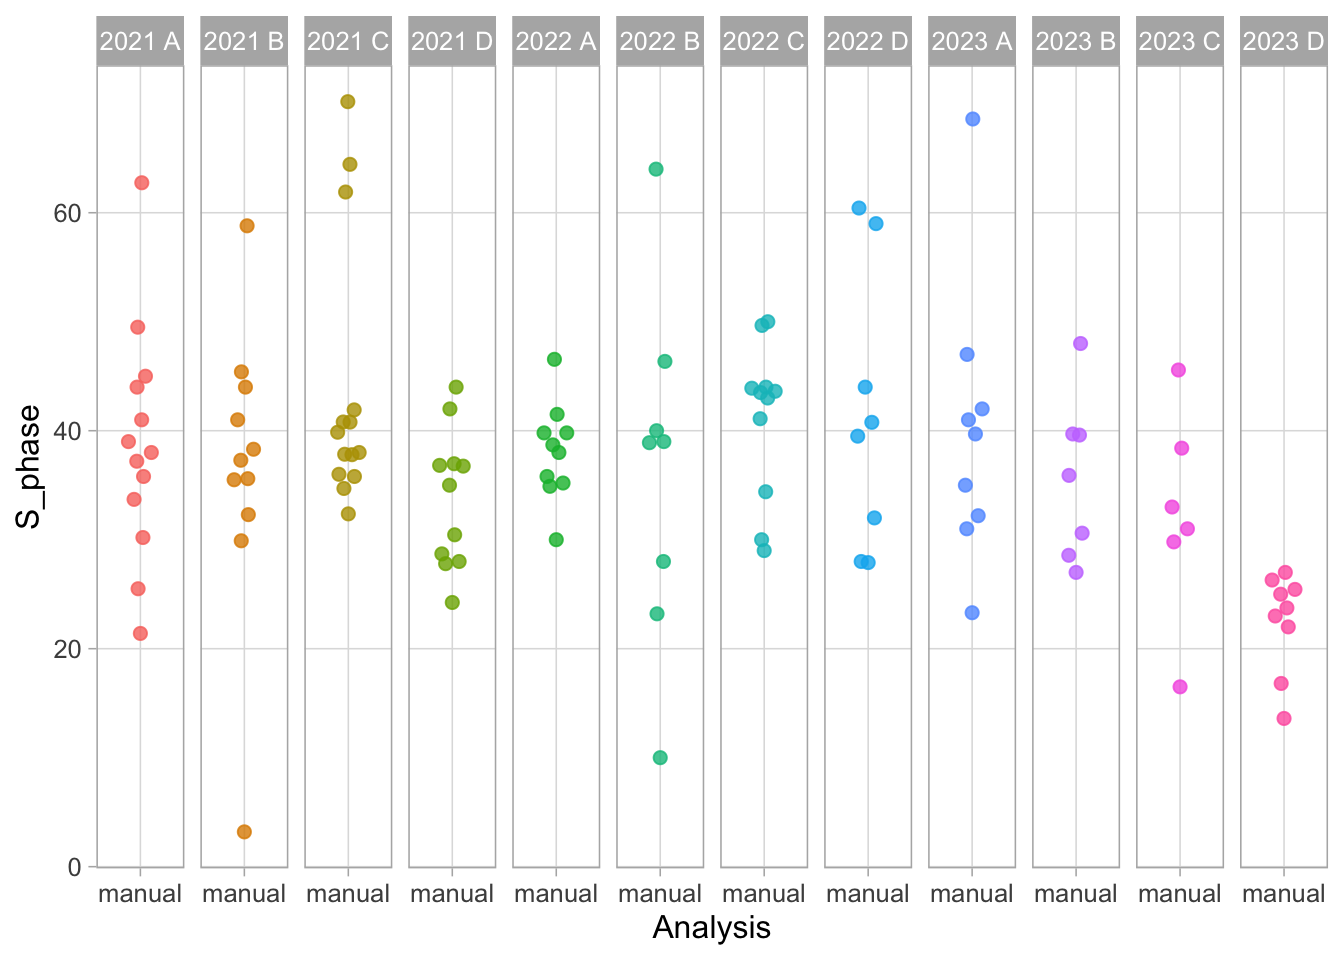

In [ ]:
p <- ggplot(df_results, (aes(x=Analysis, y=S_phase, color=Replicate, fill=Replicate)))

p <- p + geom_quasirandom(width = .2, varwidth = FALSE, cex=2, alpha=0.8, groupOnX=TRUE)

p <- p + facet_grid(.~Replicate)
p <- p + theme_light(base_size = 12) + theme(panel.grid.minor = element_blank())
p <- p + theme(legend.position="none")

p


We add the summary statistic for each replicate as a large dot. And with some styling (adjusting colors, labels), we generate the superplot:

ℹ Please use the `linewidth` aesthetic instead.

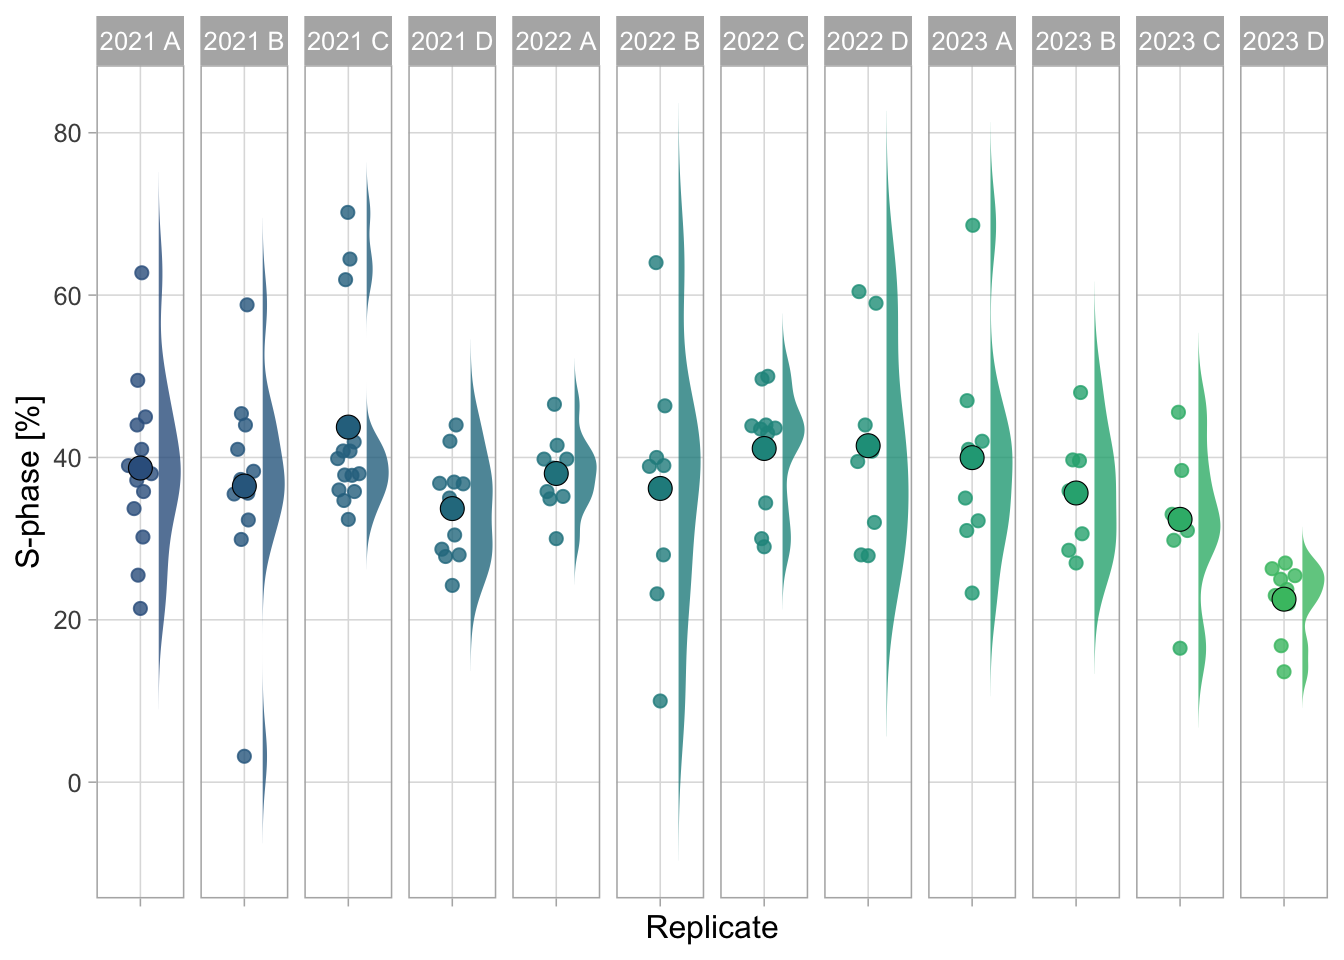

In [ ]:
p <- p + geom_flat_violin(color=NA, scale = "width", width=0.6,position = position_nudge(x = .25, y = 0), trim=FALSE, alpha = 0.8)

p <-  p + stat_summary(fun = mean, geom = "point", shape=21, stroke = .3, size=4, color="black", alpha=1)

p <- p + scale_fill_viridis_d(begin=0.3, end=0.7)
p <- p + scale_color_viridis_d(begin=0.3, end=0.7) 
p <- p + labs(x="Replicate", y="S-phase [%]")
p <- p + theme(axis.text.x = element_blank())

p


To visualize the individual independent values, with a unique color per year we can make a dotplot. The dotplot will be more valuable and informative when we have accumulated more data:

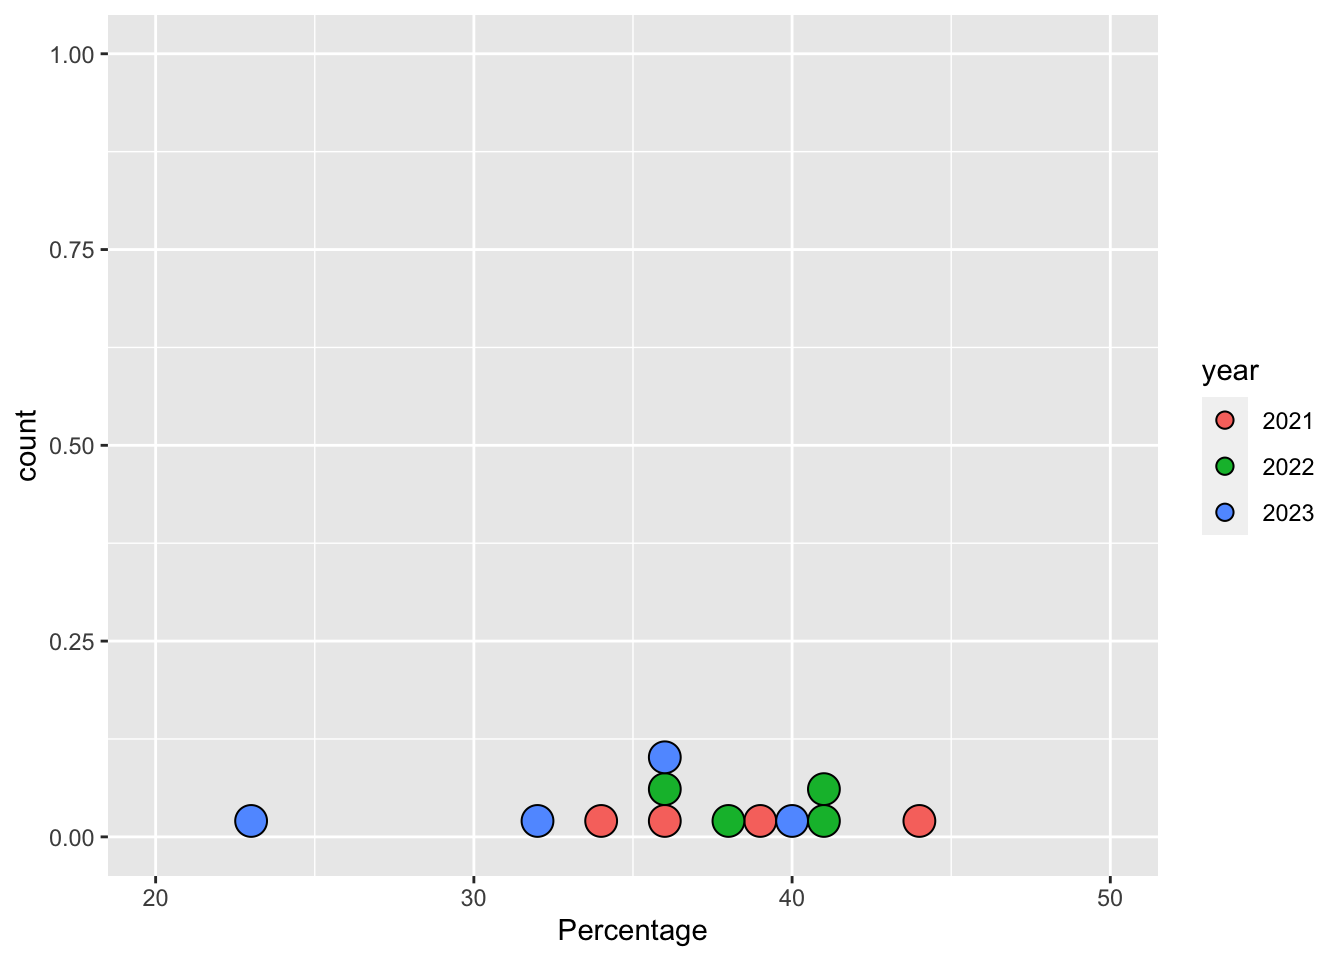

In [ ]:
df_summary %>% 
  separate(Replicate, c("year","group"), sep=" ") %>%
  ggplot(aes(x=Percentage, fill=year))+geom_dotplot(dotsize = 1, stackgroups = TRUE, binwidth = 1, method = "histodot")+xlim(20,50)
